In [172]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [173]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
dataroot = "/content/gdrive/My Drive/Colab Notebooks/hh"

workers = 2
batch_size =16
image_size=64
nc=3    #훈련 이미지의 채널 개수(R, G, B)
nz=100  #latent vector의 size (generator input의 노드 개수)
ngf=64  #generator 특징맵의 사이즈
ndf=64  #discriminator 특징맵의 사이즈
num_epoches=20
lr=0.0005
beta1=0.5 #adam optimizer의 하이퍼파라미터
ngpu=1    #가용한 gpu 대수

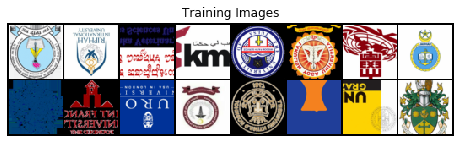

In [175]:
dataset=dset.ImageFolder(root=dataroot,
                         transform=transforms.Compose([
                                                       transforms.Resize(image_size),
                                                       transforms.CenterCrop(image_size),
                                                       transforms.ToTensor(),
                                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                         ]))


dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device=torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch=next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [178]:

netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

#  to mean=0, stdev=0.2.
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [180]:

netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

#  to mean=0, stdev=0.2.
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [0]:
# loss함수로 BCELoss function를 사용하였다.
criterion = nn.BCELoss()


#잠재공간을 만들어낸다.
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# real과 fake에 대한 레이블
real_label = 1
fake_label = 0

#Adam 옵티마이저
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [182]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epoches):
    for i, data in enumerate(dataloader, 0):

        
        #  Discriminator network 학습: maximize log(D(x)) + log(1 - D(G(z)))
        
        netD.zero_grad()
        #실제 이미지 배치로 학습
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
      
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 이미지 배치로 학습
  
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

     
        #  Generator network 학습: maximize log(D(G(z)))
    
        netG.zero_grad()
        label.fill_(real_label)  
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epoches, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

               if (iters % 500 == 0) or ((epoch == num_epoches-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/20][0/360]	Loss_D: 1.7573	Loss_G: 6.1784	D(x): 0.3237	D(G(z)): 0.2795 / 0.0144


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[0/20][50/360]	Loss_D: 1.8492	Loss_G: 11.7244	D(x): 0.6623	D(G(z)): 0.5200 / 0.0000
[0/20][100/360]	Loss_D: 1.8053	Loss_G: 3.2732	D(x): 0.6212	D(G(z)): 0.4295 / 0.1311


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[0/20][150/360]	Loss_D: 0.9502	Loss_G: 3.7889	D(x): 0.6965	D(G(z)): 0.3274 / 0.0346
[0/20][200/360]	Loss_D: 3.0638	Loss_G: 8.6164	D(x): 0.8249	D(G(z)): 0.8104 / 0.0008
[0/20][250/360]	Loss_D: 1.2186	Loss_G: 2.4579	D(x): 0.6048	D(G(z)): 0.2905 / 0.2091
[0/20][300/360]	Loss_D: 0.7463	Loss_G: 3.7785	D(x): 0.7941	D(G(z)): 0.3242 / 0.0309
[0/20][350/360]	Loss_D: 0.4040	Loss_G: 3.3494	D(x): 0.9068	D(G(z)): 0.2089 / 0.0540
[1/20][0/360]	Loss_D: 0.4671	Loss_G: 2.9696	D(x): 0.7837	D(G(z)): 0.1520 / 0.0659


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[1/20][50/360]	Loss_D: 1.6509	Loss_G: 4.0794	D(x): 0.6866	D(G(z)): 0.4134 / 0.0319
[1/20][100/360]	Loss_D: 0.6292	Loss_G: 2.7012	D(x): 0.6565	D(G(z)): 0.0736 / 0.1174
[1/20][150/360]	Loss_D: 0.9715	Loss_G: 3.2913	D(x): 0.7404	D(G(z)): 0.3704 / 0.0531
[1/20][200/360]	Loss_D: 0.6207	Loss_G: 3.4518	D(x): 0.8180	D(G(z)): 0.2715 / 0.0565
[1/20][250/360]	Loss_D: 0.3129	Loss_G: 4.8013	D(x): 0.8602	D(G(z)): 0.1109 / 0.0161
[1/20][300/360]	Loss_D: 0.7736	Loss_G: 2.4008	D(x): 0.6491	D(G(z)): 0.1078 / 0.1775
[1/20][350/360]	Loss_D: 0.4007	Loss_G: 2.6615	D(x): 0.7827	D(G(z)): 0.1046 / 0.1054
[2/20][0/360]	Loss_D: 0.6301	Loss_G: 3.9401	D(x): 0.7045	D(G(z)): 0.0568 / 0.0625
[2/20][50/360]	Loss_D: 1.6385	Loss_G: 5.2404	D(x): 0.6324	D(G(z)): 0.4693 / 0.1824


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[2/20][100/360]	Loss_D: 0.6547	Loss_G: 3.4422	D(x): 0.6205	D(G(z)): 0.0910 / 0.0616
[2/20][150/360]	Loss_D: 1.1004	Loss_G: 1.9540	D(x): 0.6194	D(G(z)): 0.2793 / 0.1933
[2/20][200/360]	Loss_D: 1.2123	Loss_G: 3.4078	D(x): 0.6140	D(G(z)): 0.3802 / 0.0416


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[2/20][250/360]	Loss_D: 0.5727	Loss_G: 3.8083	D(x): 0.8065	D(G(z)): 0.2434 / 0.0451
[2/20][300/360]	Loss_D: 0.3425	Loss_G: 4.3986	D(x): 0.7951	D(G(z)): 0.0550 / 0.0229
[2/20][350/360]	Loss_D: 0.8386	Loss_G: 3.0328	D(x): 0.8381	D(G(z)): 0.3815 / 0.0726
[3/20][0/360]	Loss_D: 0.8720	Loss_G: 3.6206	D(x): 0.7418	D(G(z)): 0.2298 / 0.0601
[3/20][50/360]	Loss_D: 0.7578	Loss_G: 3.5156	D(x): 0.8496	D(G(z)): 0.3412 / 0.0460


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[3/20][100/360]	Loss_D: 0.8265	Loss_G: 4.0585	D(x): 0.7494	D(G(z)): 0.2156 / 0.0449


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[3/20][150/360]	Loss_D: 0.4172	Loss_G: 4.2312	D(x): 0.9101	D(G(z)): 0.2513 / 0.0182
[3/20][200/360]	Loss_D: 0.6535	Loss_G: 5.1308	D(x): 0.9303	D(G(z)): 0.3653 / 0.0120
[3/20][250/360]	Loss_D: 1.7232	Loss_G: 1.5025	D(x): 0.2983	D(G(z)): 0.0837 / 0.2630
[3/20][300/360]	Loss_D: 1.4032	Loss_G: 1.8250	D(x): 0.3567	D(G(z)): 0.0283 / 0.2865
[3/20][350/360]	Loss_D: 0.6691	Loss_G: 3.6533	D(x): 0.7439	D(G(z)): 0.0990 / 0.0640


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[4/20][0/360]	Loss_D: 0.8647	Loss_G: 3.7399	D(x): 0.6227	D(G(z)): 0.0900 / 0.0448
[4/20][50/360]	Loss_D: 0.8523	Loss_G: 3.8965	D(x): 0.7794	D(G(z)): 0.2812 / 0.0481
[4/20][100/360]	Loss_D: 1.0493	Loss_G: 3.5616	D(x): 0.6062	D(G(z)): 0.2403 / 0.0396
[4/20][150/360]	Loss_D: 0.6437	Loss_G: 5.9843	D(x): 0.9046	D(G(z)): 0.3465 / 0.0272
[4/20][200/360]	Loss_D: 0.4136	Loss_G: 4.9160	D(x): 0.8247	D(G(z)): 0.0755 / 0.0101
[4/20][250/360]	Loss_D: 0.9857	Loss_G: 2.7459	D(x): 0.4755	D(G(z)): 0.0826 / 0.0983


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[4/20][300/360]	Loss_D: 0.4934	Loss_G: 5.2729	D(x): 0.7738	D(G(z)): 0.0784 / 0.0099
[4/20][350/360]	Loss_D: 0.6641	Loss_G: 5.2277	D(x): 0.8338	D(G(z)): 0.3253 / 0.0092
[5/20][0/360]	Loss_D: 0.6845	Loss_G: 4.6663	D(x): 0.9484	D(G(z)): 0.3419 / 0.0168
[5/20][50/360]	Loss_D: 0.6358	Loss_G: 4.2842	D(x): 0.6016	D(G(z)): 0.0214 / 0.0421


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[5/20][100/360]	Loss_D: 0.6750	Loss_G: 5.7011	D(x): 0.8795	D(G(z)): 0.3543 / 0.0046
[5/20][150/360]	Loss_D: 0.3383	Loss_G: 3.5695	D(x): 0.8787	D(G(z)): 0.1568 / 0.0477


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[5/20][200/360]	Loss_D: 0.4760	Loss_G: 7.0803	D(x): 0.7447	D(G(z)): 0.0594 / 0.0082
[5/20][250/360]	Loss_D: 0.7104	Loss_G: 3.5128	D(x): 0.7597	D(G(z)): 0.2433 / 0.0457
[5/20][300/360]	Loss_D: 1.6421	Loss_G: 3.0053	D(x): 0.4142	D(G(z)): 0.0828 / 0.1158
[5/20][350/360]	Loss_D: 1.7127	Loss_G: 6.4674	D(x): 0.9720	D(G(z)): 0.6940 / 0.0034
[6/20][0/360]	Loss_D: 0.7567	Loss_G: 2.7386	D(x): 0.5555	D(G(z)): 0.0269 / 0.0980


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[6/20][50/360]	Loss_D: 0.4781	Loss_G: 4.7609	D(x): 0.8227	D(G(z)): 0.2073 / 0.0158
[6/20][100/360]	Loss_D: 0.6235	Loss_G: 4.7303	D(x): 0.8343	D(G(z)): 0.3113 / 0.0364
[6/20][150/360]	Loss_D: 0.3769	Loss_G: 5.3643	D(x): 0.8635	D(G(z)): 0.1565 / 0.0171
[6/20][200/360]	Loss_D: 0.5641	Loss_G: 2.6169	D(x): 0.6937	D(G(z)): 0.0928 / 0.1179
[6/20][250/360]	Loss_D: 0.6182	Loss_G: 3.6296	D(x): 0.8659	D(G(z)): 0.3383 / 0.0319
[6/20][300/360]	Loss_D: 0.5726	Loss_G: 3.5085	D(x): 0.7495	D(G(z)): 0.1367 / 0.0592
[6/20][350/360]	Loss_D: 0.7314	Loss_G: 2.2265	D(x): 0.6427	D(G(z)): 0.1510 / 0.1624
[7/20][0/360]	Loss_D: 1.1793	Loss_G: 6.9210	D(x): 0.8526	D(G(z)): 0.5344 / 0.0027


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[7/20][50/360]	Loss_D: 0.2650	Loss_G: 4.2182	D(x): 0.8399	D(G(z)): 0.0632 / 0.0325


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[7/20][100/360]	Loss_D: 0.5113	Loss_G: 2.6192	D(x): 0.7458	D(G(z)): 0.1534 / 0.1096
[7/20][150/360]	Loss_D: 0.6909	Loss_G: 1.8191	D(x): 0.6399	D(G(z)): 0.1004 / 0.2144
[7/20][200/360]	Loss_D: 1.2583	Loss_G: 7.1934	D(x): 0.9667	D(G(z)): 0.5945 / 0.0021
[7/20][250/360]	Loss_D: 1.3662	Loss_G: 2.9924	D(x): 0.6755	D(G(z)): 0.4144 / 0.0995
[7/20][300/360]	Loss_D: 0.5153	Loss_G: 3.0843	D(x): 0.7599	D(G(z)): 0.1041 / 0.0743
[7/20][350/360]	Loss_D: 0.4184	Loss_G: 3.8356	D(x): 0.7957	D(G(z)): 0.1206 / 0.0353
[8/20][0/360]	Loss_D: 0.5431	Loss_G: 3.0478	D(x): 0.6757	D(G(z)): 0.0185 / 0.1246


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[8/20][50/360]	Loss_D: 0.8971	Loss_G: 4.1825	D(x): 0.8204	D(G(z)): 0.4083 / 0.0294
[8/20][100/360]	Loss_D: 0.6644	Loss_G: 4.2564	D(x): 0.7533	D(G(z)): 0.2364 / 0.0314
[8/20][150/360]	Loss_D: 0.1779	Loss_G: 5.6357	D(x): 0.9112	D(G(z)): 0.0648 / 0.0099
[8/20][200/360]	Loss_D: 0.2552	Loss_G: 5.3534	D(x): 0.9705	D(G(z)): 0.1877 / 0.0061
[8/20][250/360]	Loss_D: 0.2603	Loss_G: 4.6282	D(x): 0.9550	D(G(z)): 0.1735 / 0.0147
[8/20][300/360]	Loss_D: 0.1270	Loss_G: 4.6988	D(x): 0.9451	D(G(z)): 0.0619 / 0.0184
[8/20][350/360]	Loss_D: 0.4276	Loss_G: 3.2358	D(x): 0.8055	D(G(z)): 0.1172 / 0.0581
[9/20][0/360]	Loss_D: 0.7423	Loss_G: 6.5100	D(x): 0.9607	D(G(z)): 0.3825 / 0.0027
[9/20][50/360]	Loss_D: 0.7545	Loss_G: 2.8337	D(x): 0.6764	D(G(z)): 0.0875 / 0.1325
[9/20][100/360]	Loss_D: 0.5160	Loss_G: 5.3910	D(x): 0.7269	D(G(z)): 0.0092 / 0.0087


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[9/20][150/360]	Loss_D: 0.7384	Loss_G: 4.5483	D(x): 0.6250	D(G(z)): 0.1088 / 0.0298


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[9/20][200/360]	Loss_D: 0.5778	Loss_G: 6.5005	D(x): 0.9480	D(G(z)): 0.3600 / 0.0023
[9/20][250/360]	Loss_D: 0.3587	Loss_G: 5.4168	D(x): 0.9655	D(G(z)): 0.2322 / 0.0149
[9/20][300/360]	Loss_D: 0.6140	Loss_G: 3.4054	D(x): 0.6514	D(G(z)): 0.0801 / 0.0812
[9/20][350/360]	Loss_D: 0.4404	Loss_G: 4.7431	D(x): 0.7776	D(G(z)): 0.0228 / 0.0197
[10/20][0/360]	Loss_D: 0.8741	Loss_G: 7.2874	D(x): 0.9869	D(G(z)): 0.4654 / 0.0017


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[10/20][50/360]	Loss_D: 1.1084	Loss_G: 8.1622	D(x): 0.9623	D(G(z)): 0.5554 / 0.0005


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[10/20][100/360]	Loss_D: 0.4406	Loss_G: 5.4736	D(x): 0.8637	D(G(z)): 0.1718 / 0.0062
[10/20][150/360]	Loss_D: 0.0927	Loss_G: 5.7314	D(x): 0.9508	D(G(z)): 0.0374 / 0.0117
[10/20][200/360]	Loss_D: 0.3304	Loss_G: 4.6160	D(x): 0.8886	D(G(z)): 0.1649 / 0.0154
[10/20][250/360]	Loss_D: 1.4366	Loss_G: 10.2987	D(x): 0.9797	D(G(z)): 0.6125 / 0.0001
[10/20][300/360]	Loss_D: 0.6337	Loss_G: 1.6377	D(x): 0.6234	D(G(z)): 0.0284 / 0.2512
[10/20][350/360]	Loss_D: 0.3862	Loss_G: 3.9286	D(x): 0.8998	D(G(z)): 0.2040 / 0.0297
[11/20][0/360]	Loss_D: 0.4562	Loss_G: 6.0978	D(x): 0.9340	D(G(z)): 0.2660 / 0.0042


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[11/20][50/360]	Loss_D: 0.1022	Loss_G: 5.0771	D(x): 0.9398	D(G(z)): 0.0331 / 0.0175
[11/20][100/360]	Loss_D: 0.1451	Loss_G: 5.9893	D(x): 0.9321	D(G(z)): 0.0628 / 0.0073
[11/20][150/360]	Loss_D: 0.6040	Loss_G: 7.1301	D(x): 0.9865	D(G(z)): 0.3895 / 0.0020


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[11/20][200/360]	Loss_D: 0.3816	Loss_G: 6.1178	D(x): 0.9736	D(G(z)): 0.2729 / 0.0029
[11/20][250/360]	Loss_D: 0.5776	Loss_G: 2.7369	D(x): 0.6508	D(G(z)): 0.0224 / 0.1821
[11/20][300/360]	Loss_D: 0.1304	Loss_G: 5.3261	D(x): 0.9804	D(G(z)): 0.0956 / 0.0093
[11/20][350/360]	Loss_D: 0.3495	Loss_G: 3.7567	D(x): 0.8992	D(G(z)): 0.1410 / 0.0452
[12/20][0/360]	Loss_D: 0.3528	Loss_G: 5.3358	D(x): 0.9756	D(G(z)): 0.2127 / 0.0068


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[12/20][50/360]	Loss_D: 0.3494	Loss_G: 4.4602	D(x): 0.8047	D(G(z)): 0.0419 / 0.0265
[12/20][100/360]	Loss_D: 0.2356	Loss_G: 4.5391	D(x): 0.9168	D(G(z)): 0.0760 / 0.0205


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[12/20][150/360]	Loss_D: 1.0519	Loss_G: 9.3984	D(x): 0.9811	D(G(z)): 0.5079 / 0.0002
[12/20][200/360]	Loss_D: 0.3452	Loss_G: 5.0072	D(x): 0.8584	D(G(z)): 0.0719 / 0.0140
[12/20][250/360]	Loss_D: 0.2971	Loss_G: 2.5344	D(x): 0.8169	D(G(z)): 0.0534 / 0.0998
[12/20][300/360]	Loss_D: 0.1745	Loss_G: 5.4475	D(x): 0.9202	D(G(z)): 0.0750 / 0.0086
[12/20][350/360]	Loss_D: 0.3501	Loss_G: 5.6936	D(x): 0.8739	D(G(z)): 0.1181 / 0.0131
[13/20][0/360]	Loss_D: 0.4330	Loss_G: 5.7186	D(x): 0.9136	D(G(z)): 0.2373 / 0.0063


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[13/20][50/360]	Loss_D: 0.5390	Loss_G: 5.1047	D(x): 0.8498	D(G(z)): 0.2078 / 0.0356


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[13/20][100/360]	Loss_D: 0.4058	Loss_G: 5.0320	D(x): 0.8749	D(G(z)): 0.1416 / 0.0105
[13/20][150/360]	Loss_D: 0.4789	Loss_G: 6.4390	D(x): 0.9896	D(G(z)): 0.3206 / 0.0041
[13/20][200/360]	Loss_D: 0.1067	Loss_G: 4.4416	D(x): 0.9493	D(G(z)): 0.0259 / 0.0490
[13/20][250/360]	Loss_D: 0.1882	Loss_G: 4.1998	D(x): 0.9074	D(G(z)): 0.0679 / 0.0202
[13/20][300/360]	Loss_D: 0.0970	Loss_G: 6.3945	D(x): 0.9439	D(G(z)): 0.0264 / 0.0046
[13/20][350/360]	Loss_D: 0.6188	Loss_G: 7.7990	D(x): 0.6480	D(G(z)): 0.0025 / 0.0059


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[14/20][0/360]	Loss_D: 0.6865	Loss_G: 8.7737	D(x): 0.9957	D(G(z)): 0.3190 / 0.0024
[14/20][50/360]	Loss_D: 0.2413	Loss_G: 5.2168	D(x): 0.9907	D(G(z)): 0.1801 / 0.0073
[14/20][100/360]	Loss_D: 0.3313	Loss_G: 2.5952	D(x): 0.7682	D(G(z)): 0.0194 / 0.1225


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[14/20][150/360]	Loss_D: 0.2565	Loss_G: 6.0891	D(x): 0.9908	D(G(z)): 0.1853 / 0.0035
[14/20][200/360]	Loss_D: 0.4593	Loss_G: 3.9484	D(x): 0.8083	D(G(z)): 0.1020 / 0.0553
[14/20][250/360]	Loss_D: 0.7962	Loss_G: 8.5483	D(x): 0.9938	D(G(z)): 0.3934 / 0.0005
[14/20][300/360]	Loss_D: 0.1915	Loss_G: 4.6436	D(x): 0.9021	D(G(z)): 0.0677 / 0.0177
[14/20][350/360]	Loss_D: 0.3869	Loss_G: 3.3050	D(x): 0.7874	D(G(z)): 0.0758 / 0.0587
[15/20][0/360]	Loss_D: 3.6529	Loss_G: 12.5587	D(x): 0.9998	D(G(z)): 0.8987 / 0.0000


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[15/20][50/360]	Loss_D: 0.1609	Loss_G: 4.4180	D(x): 0.8740	D(G(z)): 0.0129 / 0.0197
[15/20][100/360]	Loss_D: 0.4396	Loss_G: 4.1014	D(x): 0.9967	D(G(z)): 0.2442 / 0.0381
[15/20][150/360]	Loss_D: 0.3010	Loss_G: 6.2394	D(x): 0.9667	D(G(z)): 0.2179 / 0.0046


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[15/20][200/360]	Loss_D: 0.1333	Loss_G: 5.0040	D(x): 0.9171	D(G(z)): 0.0197 / 0.0116
[15/20][250/360]	Loss_D: 0.1456	Loss_G: 5.8710	D(x): 0.9913	D(G(z)): 0.1166 / 0.0046
[15/20][300/360]	Loss_D: 0.0777	Loss_G: 6.5708	D(x): 0.9320	D(G(z)): 0.0043 / 0.0028
[15/20][350/360]	Loss_D: 0.0765	Loss_G: 5.3406	D(x): 0.9387	D(G(z)): 0.0078 / 0.0093
[16/20][0/360]	Loss_D: 0.2181	Loss_G: 4.9790	D(x): 0.8303	D(G(z)): 0.0057 / 0.0246


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[16/20][50/360]	Loss_D: 0.2490	Loss_G: 6.2712	D(x): 0.8856	D(G(z)): 0.0768 / 0.0123
[16/20][100/360]	Loss_D: 1.5658	Loss_G: 12.5352	D(x): 0.9992	D(G(z)): 0.6453 / 0.0000
[16/20][150/360]	Loss_D: 0.0289	Loss_G: 6.5659	D(x): 0.9838	D(G(z)): 0.0120 / 0.0056


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[16/20][200/360]	Loss_D: 0.0274	Loss_G: 7.8473	D(x): 0.9793	D(G(z)): 0.0057 / 0.0012
[16/20][250/360]	Loss_D: 0.1978	Loss_G: 4.3418	D(x): 0.9429	D(G(z)): 0.0983 / 0.0261
[16/20][300/360]	Loss_D: 0.0488	Loss_G: 5.6437	D(x): 0.9731	D(G(z)): 0.0200 / 0.0065
[16/20][350/360]	Loss_D: 0.2559	Loss_G: 4.5869	D(x): 0.8542	D(G(z)): 0.0296 / 0.0238
[17/20][0/360]	Loss_D: 1.0445	Loss_G: 11.0281	D(x): 0.9965	D(G(z)): 0.5288 / 0.0001


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[17/20][50/360]	Loss_D: 0.5902	Loss_G: 6.5128	D(x): 0.9882	D(G(z)): 0.2862 / 0.0050
[17/20][100/360]	Loss_D: 0.5858	Loss_G: 2.1054	D(x): 0.6406	D(G(z)): 0.0148 / 0.2954
[17/20][150/360]	Loss_D: 0.1665	Loss_G: 5.5459	D(x): 0.9265	D(G(z)): 0.0633 / 0.0081
[17/20][200/360]	Loss_D: 0.0631	Loss_G: 7.5887	D(x): 0.9512	D(G(z)): 0.0097 / 0.0028
[17/20][250/360]	Loss_D: 0.6513	Loss_G: 6.9644	D(x): 0.9412	D(G(z)): 0.3817 / 0.0019
[17/20][300/360]	Loss_D: 0.1400	Loss_G: 4.4852	D(x): 0.9794	D(G(z)): 0.1028 / 0.0197
[17/20][350/360]	Loss_D: 0.5867	Loss_G: 8.2105	D(x): 0.9868	D(G(z)): 0.3379 / 0.0031
[18/20][0/360]	Loss_D: 0.5779	Loss_G: 8.6134	D(x): 0.9883	D(G(z)): 0.2622 / 0.0011


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[18/20][50/360]	Loss_D: 0.0913	Loss_G: 4.0882	D(x): 0.9425	D(G(z)): 0.0287 / 0.0252


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[18/20][100/360]	Loss_D: 0.1394	Loss_G: 5.2650	D(x): 0.8855	D(G(z)): 0.0060 / 0.0108
[18/20][150/360]	Loss_D: 0.6832	Loss_G: 6.7434	D(x): 0.9840	D(G(z)): 0.2669 / 0.0029
[18/20][200/360]	Loss_D: 0.0872	Loss_G: 5.5550	D(x): 0.9822	D(G(z)): 0.0625 / 0.0062
[18/20][250/360]	Loss_D: 0.5861	Loss_G: 3.0541	D(x): 0.7047	D(G(z)): 0.1441 / 0.0657
[18/20][300/360]	Loss_D: 0.2074	Loss_G: 4.8068	D(x): 0.9126	D(G(z)): 0.0923 / 0.0268
[18/20][350/360]	Loss_D: 0.1241	Loss_G: 4.7053	D(x): 0.9368	D(G(z)): 0.0477 / 0.0258
[19/20][0/360]	Loss_D: 0.2270	Loss_G: 5.9272	D(x): 0.9898	D(G(z)): 0.1572 / 0.0041


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[19/20][50/360]	Loss_D: 0.4390	Loss_G: 8.9473	D(x): 0.9803	D(G(z)): 0.2691 / 0.0020
[19/20][100/360]	Loss_D: 0.0646	Loss_G: 5.0698	D(x): 0.9665	D(G(z)): 0.0272 / 0.0118
[19/20][150/360]	Loss_D: 0.1647	Loss_G: 5.4357	D(x): 0.9568	D(G(z)): 0.1071 / 0.0057
[19/20][200/360]	Loss_D: 0.3210	Loss_G: 7.6513	D(x): 0.9946	D(G(z)): 0.2144 / 0.0011
[19/20][250/360]	Loss_D: 0.2151	Loss_G: 6.3960	D(x): 0.9342	D(G(z)): 0.1100 / 0.0075
[19/20][300/360]	Loss_D: 0.0645	Loss_G: 7.9010	D(x): 0.9955	D(G(z)): 0.0536 / 0.0029
[19/20][350/360]	Loss_D: 0.1463	Loss_G: 5.5731	D(x): 0.9697	D(G(z)): 0.0891 / 0.0080


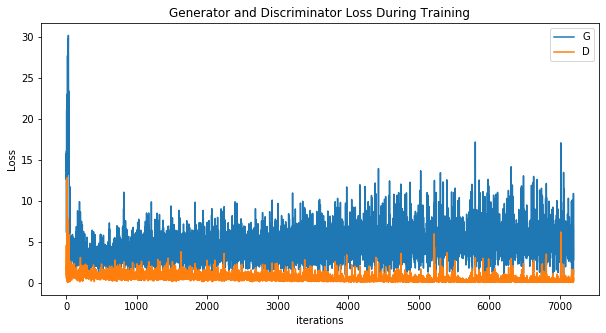

In [183]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [184]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

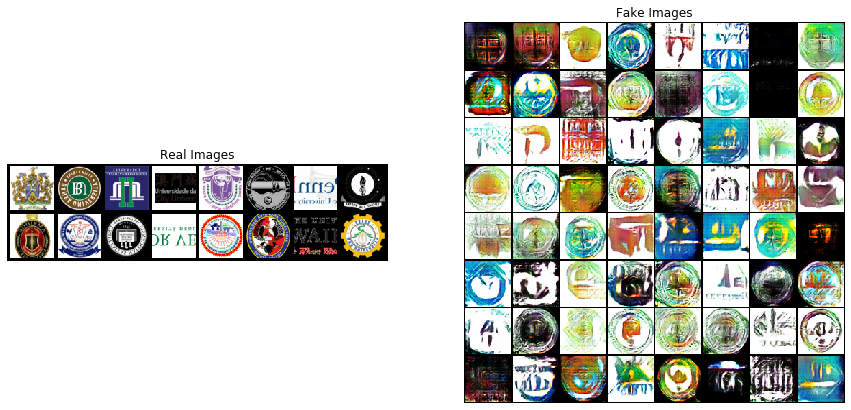

In [185]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()